# Hotel Price Prediction using Neural Networks

## Importing the libraries

In [67]:
import os, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

pathlib.Path('./models/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
pathlib.Path('./results/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
MODELS_DIR = pathlib.Path('./models/HotelPricePrediction/')
RESULTS_DIR = pathlib.Path('./results/HotelPricePrediction/')

tf.config.list_physical_devices('GPU')

[]

## Preprocessing the data

### Splitting the targets from train and test data

In [33]:
train_data = pd.read_csv('./data/trainingset.csv')
train_targets = train_data['ADR']
train_data.drop(columns=['ADR'], inplace=True)

test_data = pd.read_csv('./data/testset.csv')
test_targets = test_data['ADR']
test_data.drop(columns=['ADR'], inplace=True)


In [34]:
train_data.shape, test_data.shape

((40060, 27), (79330, 27))

### Replace the missing values with the maximum number of the column

In [35]:
train_data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
DaysInWaitingList                0
CustomerType                     0
RequiredCarParkingSpaces         0
TotalOfSpecialRequests           0
ReservationStatus                0
dtype: int64

In [36]:
train_data['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: Country, Length: 125, dtype: int64

In [37]:
train_data['Country'][train_data['Country'].isna()]

30       NaN
4127     NaN
7092     NaN
7860     NaN
8779     NaN
        ... 
26473    NaN
28460    NaN
31085    NaN
31594    NaN
33087    NaN
Name: Country, Length: 464, dtype: object

In [38]:
train_data['Country'].fillna('PRT', inplace=True)

In [39]:
train_data.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64

In [40]:
test_data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
DaysInWaitingList               0
CustomerType                    0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationStatus               0
dtype: int64

In [41]:
test_data['Children'].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [42]:
test_data['Country'].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [43]:
test_data['Children'].fillna(0, inplace=True)
test_data['Country'].fillna('PRT', inplace=True)

### Encoding the categorical data on training set

In [44]:
train_data.dtypes

IsCanceled                      int64
LeadTime                        int64
ArrivalDateYear                 int64
ArrivalDateMonth               object
ArrivalDateWeekNumber           int64
ArrivalDateDayOfMonth           int64
StaysInWeekendNights            int64
StaysInWeekNights               int64
Adults                          int64
Children                        int64
Babies                          int64
Meal                           object
Country                        object
MarketSegment                  object
DistributionChannel            object
IsRepeatedGuest                 int64
PreviousCancellations           int64
PreviousBookingsNotCanceled     int64
ReservedRoomType               object
AssignedRoomType               object
BookingChanges                  int64
DepositType                    object
DaysInWaitingList               int64
CustomerType                   object
RequiredCarParkingSpaces        int64
TotalOfSpecialRequests          int64
ReservationS

In [45]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

In [46]:
encoders_list = {col: OneHotEncoder() for col in categorical_columns}




for col in categorical_columns:
    enocded_column = encoders_list[col].fit_transform(
        train_data[[col]])
    train_data = pd.concat([train_data, pd.DataFrame(
        enocded_column.toarray(),
        columns=encoders_list[col].categories_)], axis=1)

    train_data.drop(columns=[col], inplace=True)



In [47]:
train_data.shape

(40060, 200)

### Replacing not encoded test samples with maximum of the column

In [48]:
for col in categorical_columns:
    encoder_cats = encoders_list[col].categories_[0]
    test_data_cats = np.sort(test_data[col].unique())
    not_known_cats = np.setdiff1d(test_data_cats, encoder_cats)
    if len(not_known_cats) != 0:
        print(f'Not known categories in test data for {col}: {not_known_cats}')
        print('Unknown categories samples in test data for {}: {}'.format(
            col, test_data[col].isin(not_known_cats).sum()))

        most_frequent_cat = test_data[col].value_counts().index[0]
        print('Replacing with most frequent category: {}'.format(
            most_frequent_cat))
        test_data[col].replace(not_known_cats, most_frequent_cat, inplace=True)
        print('Processed')
        print('--------------------------------------------')


Not known categories in test data for Country: ['ABW' 'AIA' 'ASM' 'ATA' 'ATF' 'BEN' 'BFA' 'BGD' 'BOL' 'BRB' 'DMA' 'ETH'
 'FRO' 'GAB' 'GHA' 'GLP' 'GNB' 'GTM' 'GUY' 'HND' 'IMN' 'IRQ' 'KEN' 'KHM'
 'KIR' 'KNA' 'LAO' 'LBY' 'LCA' 'LIE' 'MCO' 'MLI' 'MMR' 'MNE' 'MRT' 'MYT'
 'NAM' 'NCL' 'NIC' 'PAN' 'PRY' 'PYF' 'RWA' 'SDN' 'SLE' 'SLV' 'STP' 'TJK'
 'TMP' 'TZA' 'UMI' 'VGB']
Unknown categories samples in test data for Country: 170
Replacing with most frequent category: PRT
Processed
--------------------------------------------
Not known categories in test data for MarketSegment: ['Aviation' 'Undefined']
Unknown categories samples in test data for MarketSegment: 239
Replacing with most frequent category: Online TA
Processed
--------------------------------------------
Not known categories in test data for DistributionChannel: ['GDS']
Unknown categories samples in test data for DistributionChannel: 193
Replacing with most frequent category: TA/TO
Processed
--------------------------------------------

### Encoding the categorical data on test set

In [49]:
for col in categorical_columns:
    test_data = pd.concat([test_data, pd.DataFrame(
        encoders_list[col].transform(
        test_data[[col]]).toarray(),
        columns=encoders_list[col].categories_)], axis=1)

    test_data.drop(columns=[col], inplace=True)


In [50]:
test_data.shape

(79330, 200)

### Converting the data and targets into tensors

In [51]:
train_data = tf.convert_to_tensor(train_data.values,
                                        dtype=tf.float64)
train_targets = tf.convert_to_tensor(train_targets.values,
                                     dtype=tf.float64)

test_data = tf.convert_to_tensor(test_data.values,
                                 dtype=tf.float64)
test_targets = tf.convert_to_tensor(test_targets.values,
                                    dtype=tf.float64)

In [52]:
train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

(TensorShape([40060, 200]),
 TensorShape([40060]),
 TensorShape([79330, 200]),
 TensorShape([79330]))

In [53]:
train_data.device, train_targets.device, test_data.device, test_targets.device

('/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:CPU:0')

In [54]:
train_data.dtype, train_targets.dtype, test_data.dtype, test_targets.dtype

(tf.float64, tf.float64, tf.float64, tf.float64)

### Standardization of train and test data

In [55]:
mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Designing The Neural Network Model

### Multi Layer Perceptron Archtiecture

In [56]:
from tensorflow.keras import models, layers
from tensorflow import keras

inputs = keras.Input(shape=(train_data.shape[1],))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_7 (Dense)             (None, 32)                6432      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

### Compiling the model

In [57]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

### Training the model with differnet number of epochs

In [58]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_extraction.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=callbacks)


Epoch 1/30
501/501 [==============================] - 2s 3ms/step - loss: 1562.0844 - mae: 25.0126 - val_loss: 863.9676 - val_mae: 19.7772
Epoch 2/30
501/501 [==============================] - 1s 2ms/step - loss: 802.4030 - mae: 18.5822 - val_loss: 904.6376 - val_mae: 20.7438
Epoch 3/30
501/501 [==============================] - 1s 2ms/step - loss: 691.3983 - mae: 17.3214 - val_loss: 716.9836 - val_mae: 17.6681
Epoch 4/30
501/501 [==============================] - 1s 2ms/step - loss: 624.4256 - mae: 16.5172 - val_loss: 832.9062 - val_mae: 19.2034
Epoch 5/30
501/501 [==============================] - 1s 2ms/step - loss: 592.7159 - mae: 16.0100 - val_loss: 686.6800 - val_mae: 17.0327
Epoch 6/30
501/501 [==============================] - 1s 3ms/step - loss: 574.3716 - mae: 15.6889 - val_loss: 683.0432 - val_mae: 17.0704
Epoch 7/30
501/501 [==============================] - 1s 2ms/step - loss: 539.7531 - mae: 15.2317 - val_loss: 705.8127 - val_mae: 17.3701
Epoch 8/30
501/501 [=============

In [59]:
import matplotlib.pyplot as plt


def plot_history(history):
    """Plot training and validation MSE loss and MAE metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title('Training and validation loss')

    epochs = range(1, len(history.history['mae']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss(MSE)')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss(MSE)')
    plt.title('Training and validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(MSE)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

    plt.show()


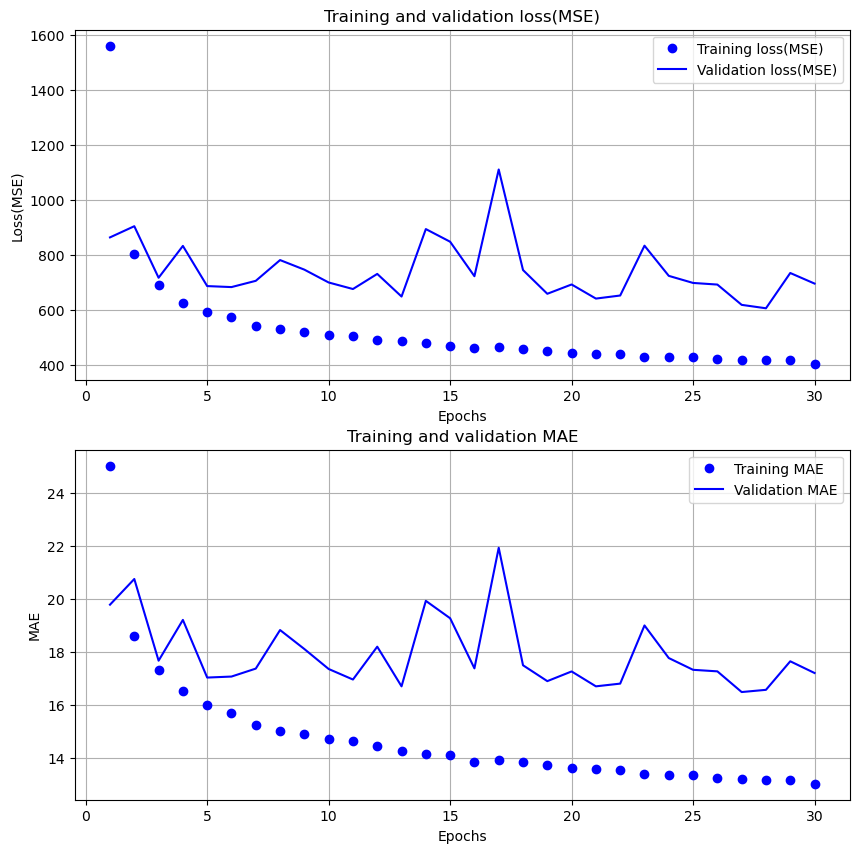

In [60]:
plot_history(history)

Continuing the training with extra epochs

Epoch 1/50
501/501 [==============================] - 1s 2ms/step - loss: 408.4070 - mae: 13.0755 - val_loss: 637.9476 - val_mae: 16.7662
Epoch 2/50
501/501 [==============================] - 1s 2ms/step - loss: 408.4032 - mae: 13.0201 - val_loss: 640.3839 - val_mae: 16.8252
Epoch 3/50
501/501 [==============================] - 1s 2ms/step - loss: 403.2838 - mae: 12.9185 - val_loss: 617.7293 - val_mae: 16.5072
Epoch 4/50
501/501 [==============================] - 1s 2ms/step - loss: 400.2966 - mae: 12.9245 - val_loss: 618.7538 - val_mae: 16.6365
Epoch 5/50
501/501 [==============================] - 1s 3ms/step - loss: 395.3245 - mae: 12.8603 - val_loss: 686.4902 - val_mae: 17.0513
Epoch 6/50
501/501 [==============================] - 1s 2ms/step - loss: 394.3318 - mae: 12.8272 - val_loss: 708.7537 - val_mae: 17.5049
Epoch 7/50
501/501 [==============================] - 1s 2ms/step - loss: 396.2148 - mae: 12.8591 - val_loss: 630.6614 - val_mae: 16.5885
Epoch 8/50
501/501 [==============

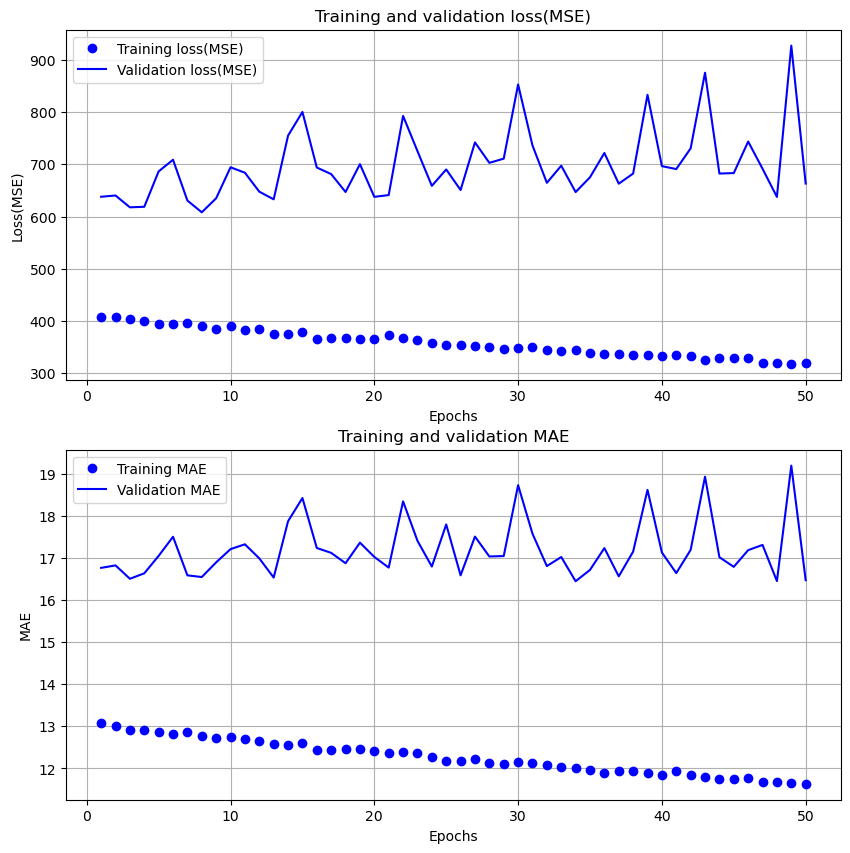

In [61]:
history = model.fit(train_data, train_targets, validation_split=0.2 ,epochs=50,
                    batch_size=64, callbacks=callbacks)
plot_history(history)


Epoch 1/100
501/501 [==============================] - 2s 3ms/step - loss: 411.8571 - mae: 13.1430 - val_loss: 635.3090 - val_mae: 16.7151
Epoch 2/100
501/501 [==============================] - 1s 2ms/step - loss: 407.6032 - mae: 13.0136 - val_loss: 689.9136 - val_mae: 17.5472
Epoch 3/100
501/501 [==============================] - 1s 2ms/step - loss: 408.7766 - mae: 13.0617 - val_loss: 872.7690 - val_mae: 19.5078
Epoch 4/100
501/501 [==============================] - 1s 2ms/step - loss: 405.4786 - mae: 12.9755 - val_loss: 843.1556 - val_mae: 19.3513
Epoch 5/100
501/501 [==============================] - 1s 3ms/step - loss: 400.9942 - mae: 12.9744 - val_loss: 690.2314 - val_mae: 17.3698
Epoch 6/100
501/501 [==============================] - 1s 2ms/step - loss: 400.7057 - mae: 12.9115 - val_loss: 754.3329 - val_mae: 18.0983
Epoch 7/100
501/501 [==============================] - 1s 2ms/step - loss: 393.0840 - mae: 12.8298 - val_loss: 641.0866 - val_mae: 16.7406
Epoch 8/100
501/501 [======

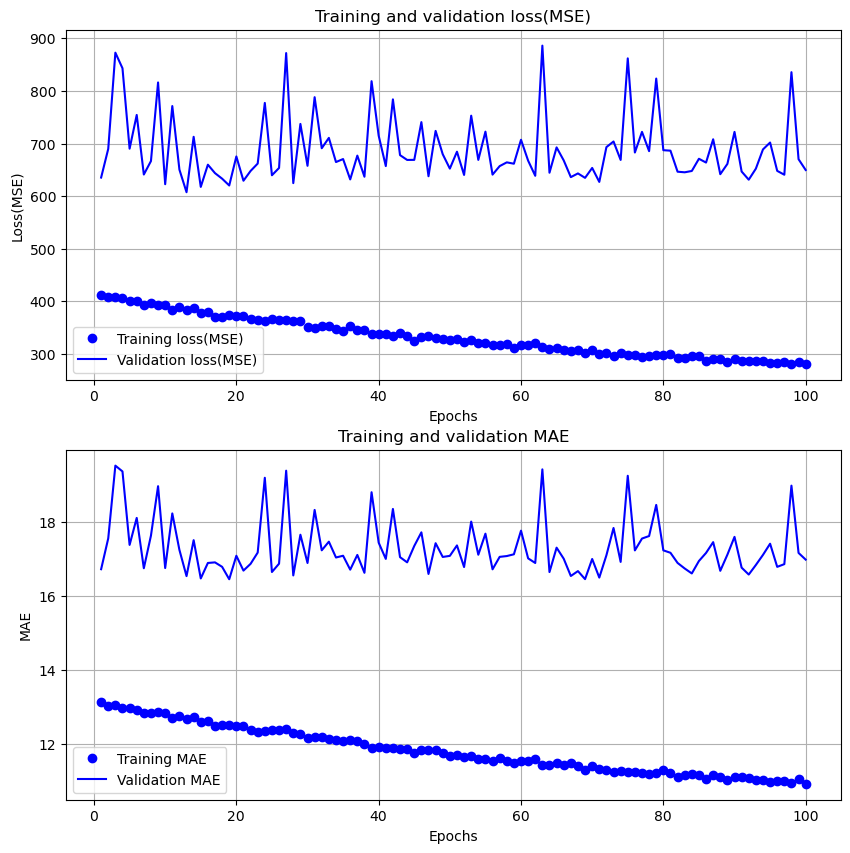

In [66]:
history = model.fit(train_data, train_targets, validation_split=0.2,
                    epochs=100, batch_size=64, callbacks=callbacks)

plot_history(history)


## Evaluating the model on test data

In [68]:
model = keras.models.load_model(os.path.join(
    MODELS_DIR, 'MLP_arch_without_feature_extraction.keras'))

test_predictions = model.predict(test_data)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2480/2480 [==============================] - 2s 770us/step - loss: 3561.7839 - mae: 48.5235


### Saving the results

In [64]:
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})

results_df.head(10)


,Actual,Predicted,Error
0,0.00,71.206146,-71.206146
1,76.50,87.560463,-11.060463
2,68.00,78.421066,-10.421066
3,76.50,86.858955,-10.358955
4,76.50,91.315025,-14.815025
5,76.50,88.321953,-11.821953
6,58.67,81.688972,-23.018972
7,68.00,76.647942,-8.647942
8,76.50,79.682457,-3.182457
9,76.50,79.682457,-3.182457


In [69]:
results_df.to_csv(os.path.join(RESULTS_DIR, 'Results.csv'), index=False)
